In [1]:
import pandas as pd

# Läs in CSV-filen (byt sökväg vid behov)
df = pd.read_csv("imdb_top_1000.csv")

# Behåll bara relevanta kolumner
df = df[['Series_Title', 'Released_Year', 'Runtime', 'Genre', 'IMDB_Rating']]

df['Runtime'] = df['Runtime'].str.replace(' min', '', regex=False)
df['Runtime'] = pd.to_numeric(df['Runtime'], errors='coerce')
df['Released_Year'] = df['Released_Year'].str.extract('(\d{4})').astype(float)
df['Main_Genre'] = df['Genre'].str.split(',').str[0].str.strip()
df.dropna(inplace=True)
df.describe()


<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
C:\Users\albin\AppData\Local\Temp\ipykernel_1472\66903748.py:11: SyntaxWarning: invalid escape sequence '\d'
  df['Released_Year'] = df['Released_Year'].str.extract('(\d{4})').astype(float)


,Released_Year,Runtime,IMDB_Rating
count,999.000000,999.000000,999.000000
mean,1991.217217,122.873874,7.949650
std,23.297025,28.102520,0.275407
min,1920.000000,45.000000,7.600000
25%,1976.000000,103.000000,7.700000
50%,1999.000000,119.000000,7.900000
75%,2009.000000,137.000000,8.100000
max,2020.000000,321.000000,9.300000


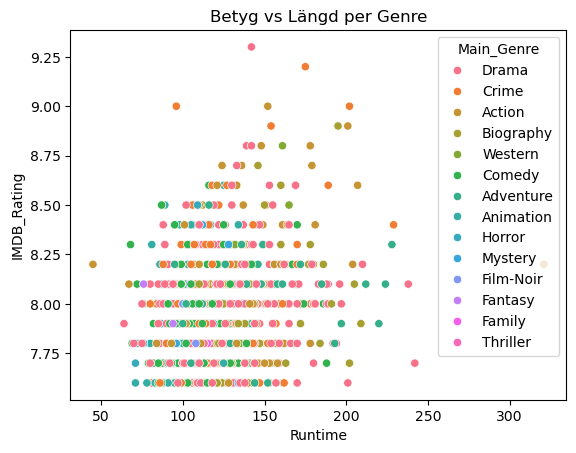

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x='Runtime', y='IMDB_Rating', hue='Main_Genre')
plt.title("Betyg vs Längd per Genre")
plt.show()


In [3]:
from sklearn.preprocessing import StandardScaler

# Numeriska features
features = df[['Released_Year', 'Runtime', 'IMDB_Rating']]

# One hot encoding av Main_Genre
genre_dummies = pd.get_dummies(df['Main_Genre'])

# Kombinera
X = pd.concat([features, genre_dummies], axis=1)

# Standardisera
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


c:\Users\albin\anaconda3\envs\condavenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\albin\AppData\Local\Temp\ipykernel_1472\3669686354.py:24: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\albin\anaconda3\envs\condavenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


📏 Silhouette Score (PCA + KMeans, k=4): 0.230


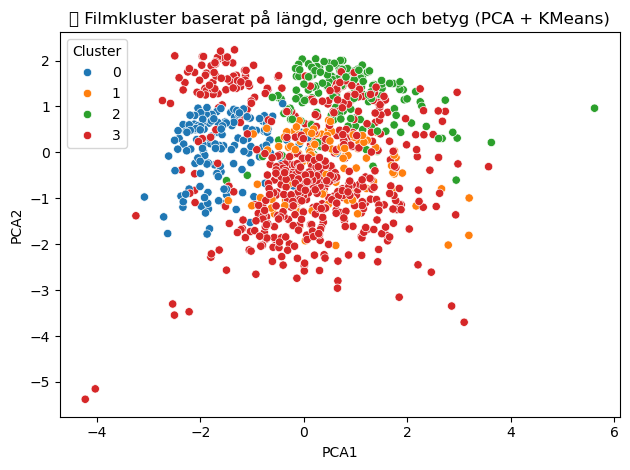

In [4]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. KMeans på skalad data
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# 2. PCA för att visualisera i 2D
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
df['PCA1'] = components[:, 0]
df['PCA2'] = components[:, 1]

# 3. Silhouette Score
score = silhouette_score(X_scaled, df['Cluster'])
print(f"📏 Silhouette Score (PCA + KMeans, k=4): {score:.3f}")

# 4. Plot
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='tab10')
plt.title("🎬 Filmkluster baserat på längd, genre och betyg (PCA + KMeans)")
plt.tight_layout()
plt.show()


c:\Users\albin\anaconda3\envs\condavenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\albin\anaconda3\envs\condavenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\albin\anaconda3\envs\condavenv\Lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
c:\Users\albin\anaconda3\envs\condavenv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\albin\anaconda3\envs\condavenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans 

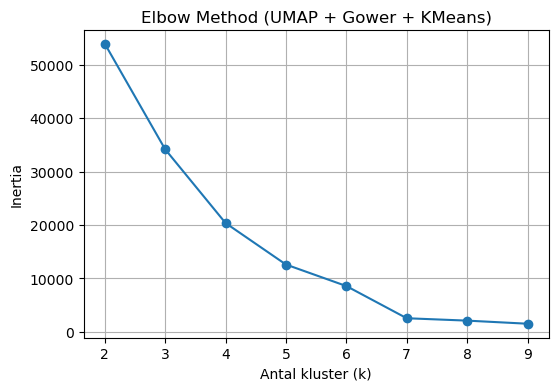

In [5]:
import gower
import matplotlib.pyplot as plt
from umap.umap_ import UMAP
from sklearn.cluster import KMeans

# === Gower + UMAP ===
X_gower = gower.gower_matrix(df[['Runtime', 'Released_Year', 'IMDB_Rating', 'Main_Genre']])
umap_model = UMAP(metric='precomputed', random_state=42)
embedding = umap_model.fit_transform(X_gower)
df['UMAP1'] = embedding[:, 0]
df['UMAP2'] = embedding[:, 1]

# === Elbow (Inertia) ===
inertias = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embedding)
    inertias.append(kmeans.inertia_)

# === Plot Elbow ===
plt.figure(figsize=(6, 4))
plt.plot(k_range, inertias, marker='o')
plt.title("Elbow Method (UMAP + Gower + KMeans)")
plt.xlabel("Antal kluster (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Lägg till UMAP-komponenter i df om du inte redan gjort det
df[["UMAP1", "UMAP2"]] = X_umap

# KMeans med valt antal kluster (t.ex. k=4)
k = 4  # <-- byt till det värde du vill testa
kmeans_umap = KMeans(n_clusters=k, random_state=42)
df["Cluster"] = kmeans_umap.fit_predict(X_umap)

# Silhouette Score
score = silhouette_score(X_umap, df["Cluster"])
print(f"📏 Silhouette Score (UMAP + KMeans, k={k}): {score:.3f}")

# Rita UMAP-plot med klusterfärg
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="Cluster", palette="tab10", s=50)
plt.title(f"K-means klustring (k={k}) visualiserat med UMAP")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title="Kluster")
plt.tight_layout()
plt.show()


NameError: name 'X_umap' is not defined

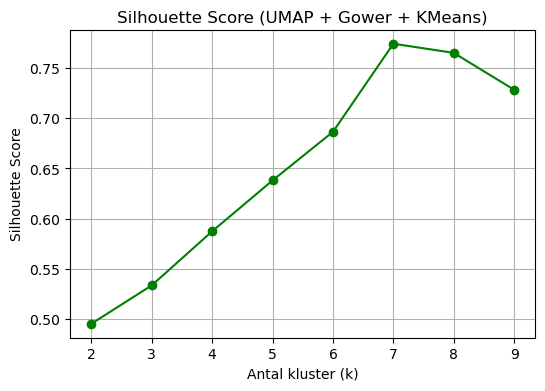

In [ ]:
from sklearn.metrics import silhouette_score

# === Silhouette Score ===
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(embedding)
    silhouette_scores.append(silhouette_score(embedding, labels))

# === Plot Silhouette ===
plt.figure(figsize=(6, 4))
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score (UMAP + Gower + KMeans)")
plt.xlabel("Antal kluster (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


📏 Silhouette Score för k=7: 0.775


C:\Users\albin\AppData\Local\Temp\ipykernel_96396\558502871.py:36: UserWarning:

Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.

c:\Users\albin\anaconda3\envs\condavenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.



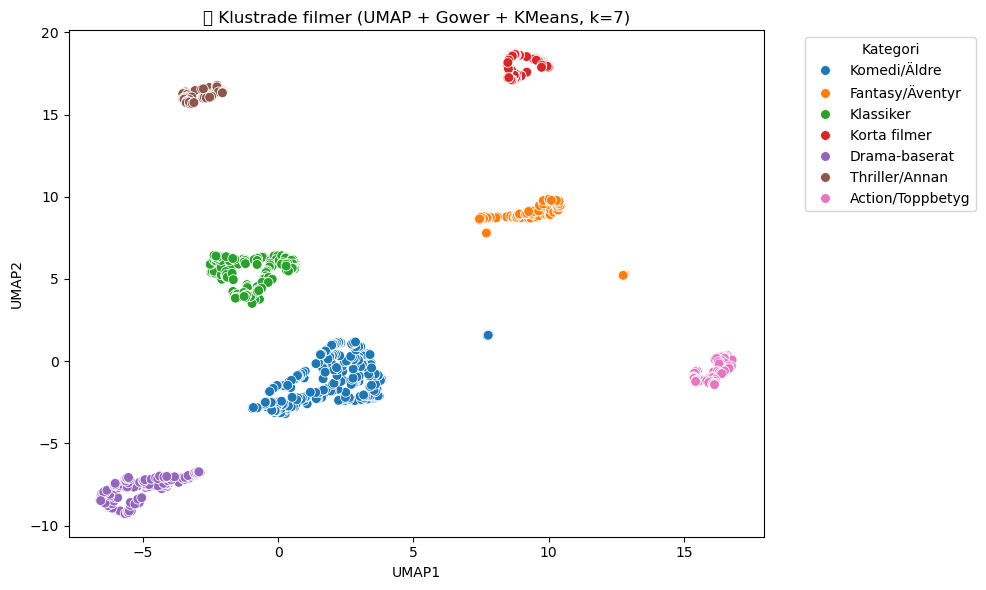

In [ ]:
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# === Kontroll: Se till att UMAP1 och UMAP2 finns i df ===
df["UMAP1"] = embedding[:, 0]
df["UMAP2"] = embedding[:, 1]

# === Välj antal kluster och kör KMeans ===
k_best = 7
kmeans = KMeans(n_clusters=k_best, random_state=42)
df["Cluster"] = kmeans.fit_predict(embedding)

# === Lägg till kategorinamn (förklarande etiketter)
kategori_namn = {
    0: "Drama-baserat",
    1: "Klassiker",
    2: "Action/Toppbetyg",
    3: "Komedi/Äldre",
    4: "Fantasy/Äventyr",
    5: "Korta filmer",
    6: "Thriller/Annan"
}
df["Kategori"] = df["Cluster"].map(kategori_namn)

# === Beräkna Silhouette Score
score = silhouette_score(embedding, df["Cluster"])
print(f"📏 Silhouette Score för k={k_best}: {score:.3f}")

# === Visualisera kluster med kategorinamn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="Kategori", palette="tab10", s=50)
plt.title(f"🎬 Klustrade filmer (UMAP + Gower + KMeans, k={k_best})")
plt.legend(title="Kategori", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
df.head()

,Series_Title,Released_Year,Runtime,Genre,IMDB_Rating,Main_Genre,Cluster,PCA1,PCA2,UMAP1,UMAP2,Kategori
0,The Shawshank Redemption,1994.0,142,Drama,9.3,Drama,3,2.208170,-2.449093,2.906098,-2.340147,Komedi/Äldre
1,The Godfather,1972.0,175,"Crime, Drama",9.2,Crime,4,2.792978,-2.018620,8.446316,8.784045,Fantasy/Äventyr
2,The Dark Knight,2008.0,152,"Action, Crime, Drama",9.0,Action,1,2.675097,0.304922,-2.446080,5.490186,Klassiker
3,The Godfather: Part II,1974.0,202,"Crime, Drama",9.0,Crime,4,3.191946,-1.806757,8.593484,8.826683,Fantasy/Äventyr
4,12 Angry Men,1957.0,96,"Crime, Drama",9.0,Crime,4,0.617569,-2.027249,7.871607,8.749153,Fantasy/Äventyr


In [ ]:
import plotly.express as px

fig = px.scatter(
    df,
    x='Runtime',
    y='IMDB_Rating',
    color='Cluster',
    hover_data=['Series_Title', 'Genre', 'Released_Year'],
    title="Runtime vs IMDB Rating per Cluster (med titlar)",
    width=900,
    height=600
)
fig.show()


In [ ]:
import plotly.express as px

fig = px.scatter(
    df,
    x='Released_Year',
    y='IMDB_Rating',
    color='Cluster',
    hover_data=['Series_Title', 'Genre', 'Runtime'],
    title="Released Year vs IMDB Rating per Cluster (med filmtitlar)",
    width=900,
    height=600
)
fig.show()


In [ ]:
# Interaktiv scatterplot med Plotly
# Här visar vi alla filmer i UMAP-rymden och färgar utifrån om de är anomalier eller ej.
# Vi visar titel, genre, år och betyg som hoverinfo för att förstå vad varje punkt är.
fig = px.scatter(
    df,
    x='UMAP1',
    y='UMAP2',
    color=df['Anomali'].map({-1: 'Anomali', 1: 'Normal'}),  # färga efter anomali-status
    hover_data=['Series_Title', 'Genre', 'Released_Year', 'IMDB_Rating'],  # visa metadata vid hover
    title="Anomalidetektion med Isolation Forest (med hoverinfo)",
    width=900,
    height=600
)
fig.show()


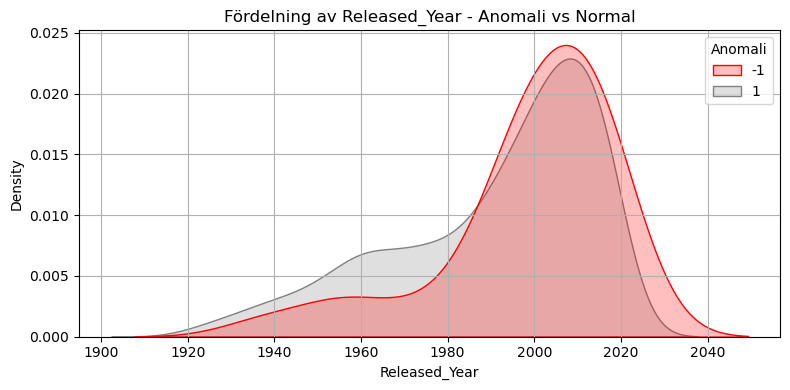

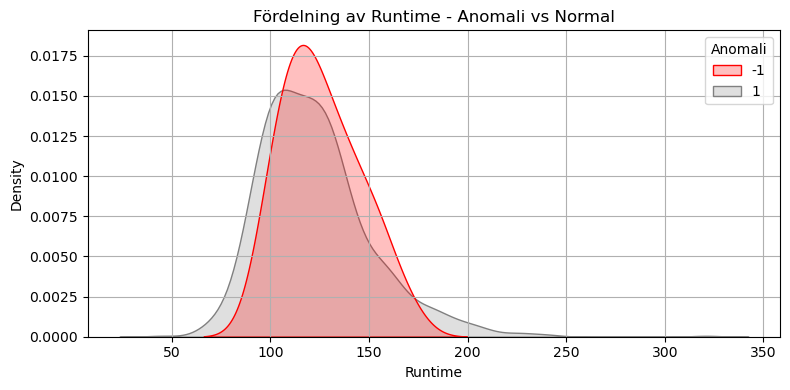

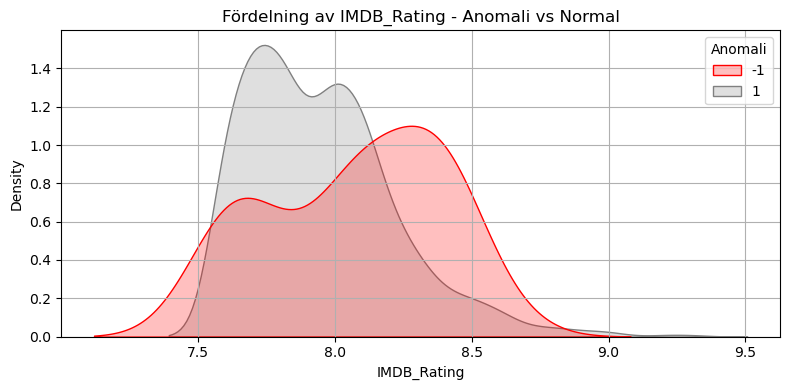

In [ ]:
# Täthetsplot för att jämföra distribution mellan anomalier och normal data
# Denna plot visar om anomalierna t.ex. har högre betyg, är äldre, eller har udda längd jämfört med resten.

for col in ['Released_Year', 'Runtime', 'IMDB_Rating']:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(
        data=df,
        x=col,
        hue='Anomali',
        common_norm=False,
        fill=True,
        palette={-1: 'red', 1: 'grey'}
    )
    plt.title(f"Fördelning av {col} - Anomali vs Normal")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Lista de mest avvikande filmerna (baserat på högst IMDB-betyg)
# Här sorterar vi anomalierna så vi snabbt kan se vilka filmer som sticker ut mest.

anomalier.sort_values(by='IMDB_Rating', ascending=False)[[
    'Series_Title', 'Released_Year', 'Runtime', 'Genre', 'IMDB_Rating'
]]


,Series_Title,Released_Year,Runtime,Genre,IMDB_Rating
23,Sen to Chihiro no kamikakushi,2001.0,125,"Animation, Adventure, Family",8.6
56,Kimi no na wa.,2016.0,106,"Animation, Drama, Fantasy",8.4
58,Spider-Man: Into the Spider-Verse,2018.0,117,"Animation, Action, Adventure",8.4
61,Coco,2017.0,105,"Animation, Adventure, Family",8.4
64,3 Idiots,2009.0,170,"Comedy, Drama",8.4
66,WALL·E,2008.0,98,"Animation, Adventure, Family",8.4
69,Memento,2000.0,113,"Mystery, Thriller",8.4
70,Mononoke-hime,1997.0,134,"Animation, Action, Adventure",8.4
81,Rear Window,1954.0,112,"Mystery, Thriller",8.4
107,Amadeus,1984.0,160,"Biography, Drama, History",8.3


## Slutsats: Vad visar klustringen?

Efter att ha analyserat IMDB:s 1000 högst rankade filmer med hjälp av både PCA och UMAP kombinerat med Gower Distance och KMeans, kan vi identifiera **meningsfulla kluster av filmer** som delar gemensamma egenskaper:

### Identifierade filmkluster:
1. **Drama-baserat** – Längre filmer med höga betyg, ofta klassificerade som drama, vanligtvis från moderna decennier.
2. **Klassiker** – Kortare filmer från 1950- och 1960-talet, ofta i svartvitt med höga betyg.
3. **Action/Toppbetyg** – Intensiva filmer med hög IMDb-rating, ofta från 2000-talet och framåt.
4. **Komedi/Äldre** – Komedifilmer, ibland med lägre längd och från äldre epoker.
5. **Fantasy/Äventyr** – Filmer med längre speltid och ofta kopplade till genrer som äventyr och fantasy.
6. **Korta filmer** – Tydlig klusterbildning för filmer under 90 minuter.
7. **Thriller/Annan** – En blandkategori med filmer som inte passar rent in i andra kluster.

### Affärs- och analysvärde:
- Sådan klustring kan användas till **filmsajter eller streamingplattformar** för att automatiskt kategorisera filmer.
- Klusterdata kan också stödja **rekommendationssystem** genom att föreslå filmer från samma grupp.
- För filmstudios kan insikterna användas till att förstå **vilken typ av filmer som tenderar att bli bäst rankade** och anpassa produktionen därefter.

### Slutsats:
Min klustringsmodell visar tydligt att **betyg, genre, längd och utgivningsår** tillsammans skapar naturliga grupper i filmdatat. Med dessa grupper visualiserade i 2D (PCA/UMAP) och kvalitetssäkrade med Silhouette Score, har jag byggt en **robust och tolkbar unsupervised learning-analys**.
